# Full wave inversion

## Setup the problem

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from jax import numpy as jnp
import numpy as np

In [3]:
# Defining geometry
from jwave.geometry import kGrid, TimeAxis, Medium, Sources, Sensors, _points_on_circle, _circ_mask
from jwave.physics import simulate_wave_propagation

N = (128, 128)
dx = (.5, .5)

cfl = 0.25

grid = kGrid.make_grid(N, dx)

In [4]:
# Physical properties
sound_speed = jnp.ones(N) 
circle_1 = _circ_mask(N, 8, (50,50))
circle_2 = _circ_mask(N, 10, (78,64))
circle_3 = _circ_mask(N, 20, (65,65))
sound_speed = sound_speed + 0.1*circle_1 + 0.13*circle_2 + 0.07*circle_3

# Physical properties
medium = Medium(
    sound_speed=sound_speed,
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=20
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=80.)
output_time_array = TimeAxis(dt = time_array.dt,t_end = time_array.t_end)

In [5]:
# define a source point
from jwave.signal_processing import gaussian_window, apply_ramp

num_sources = 32
source_freq = .5
source_mag = 5/time_array.dt


t = jnp.arange(0, time_array.t_end, time_array.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, time_array.dt, source_freq), t, 5, 2)

mask = _circ_mask(N, 38, (64,64))
x, y = _points_on_circle(num_sources,40,(64,64))
source_positions = (jnp.array(x), jnp.array(y))

In [6]:
# Define sensors
sensors_positions = (x, y)
sensors = Sensors(positions=sensors_positions)

Let's look at the problem setup

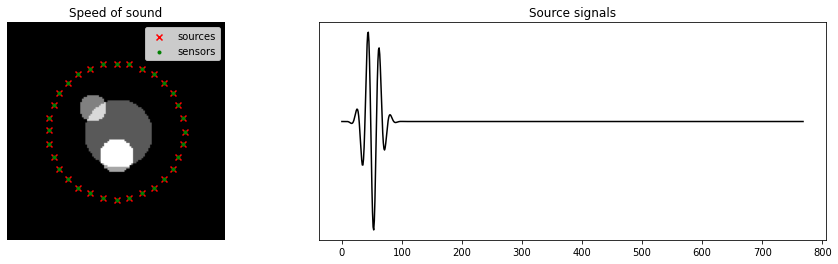

In [7]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed, cmap="gray")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='.', label="sensors")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c='k')
ax[1].set_title("Source signals")
ax[1].get_yaxis().set_visible(False)

## Run the simulation

In [8]:
from functools import partial
import jax

src_signal = jnp.stack([signal])

@jax.jit
def single_source_simulation(speed_of_sound, source_num):
    # Setting source
    x = jax.lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = jax.lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x,y), src_signal)
    new_medium = Medium(
        sound_speed=speed_of_sound,
        density=1.0,
        attenuation=0.0,
        pml_size=20
    )
    
    # Run simulations
    fields = simulate_wave_propagation(grid, new_medium, time_array, sources, sensors,
                                  output_t_axis = output_time_array, backprop=True)
    
    # Return pressure
    p = jnp.sum(fields[1],1)*(medium.sound_speed[sources.positions]**2)
    return p

batch_simulations = jax.jit(jax.vmap(single_source_simulation, (None,0), 0))

In [9]:
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))

In [10]:
# Run simulation
p = single_source_simulation(medium.sound_speed, 1)

In [11]:
%%timeit
single_source_simulation(medium.sound_speed, 1)

165 ms ± 36.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
batch_simulations(medium.sound_speed, jnp.arange(num_sources))

540 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define the optimization problem

In [13]:
from jax import random, nn, value_and_grad, jit, jvp, grad, vmap, jacfwd
from jax import lax
from jax.experimental import stax
from jwave.signal_processing import smooth, apply_ramp

key = random.PRNGKey(42)

In [14]:
def get_sound_speed(params):
    return jnp.ones(N) + nn.sigmoid(params)*mask

In [15]:
def init_sos():
    old_sos_params = jnp.log((medium.sound_speed - 0.99)/(1-medium.sound_speed + 0.99))
    for _ in range(100):
        old_sos_params= smooth(old_sos_params)
    return old_sos_params
params = init_sos()
sos = get_sound_speed(params)

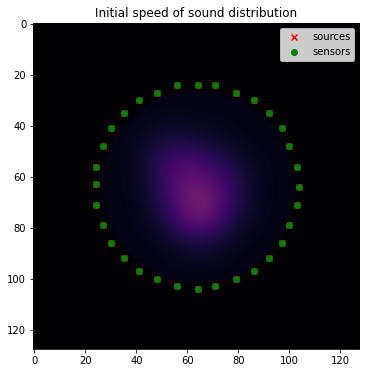

In [16]:
def plot_sos(sos, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,6))

        ax.imshow(sos, cmap="inferno", vmax=1.3)
        ax.scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
        ax.scatter(sensors_positions[1],sensors_positions[0], c='g', marker='o', label="sensors")
        ax.legend()

plot_sos(sos)
plt.title("Initial speed of sound distribution")
plt.show()

In [17]:
def loss_func(p, source_num):
    '''
    Maximizes energy at central sensor, minimize energy external ones'''
    diff = p_data[source_num] - p
    return 1e3*jnp.mean(jnp.abs(diff)**2)
                
def get_sensor_signals(params, source_num):
    p = single_source_simulation(get_sound_speed(params), source_num)
    return p

def loss_with_grad(params, source_num):
    lossval, gradient = value_and_grad(
        lambda x: loss_func(get_sensor_signals(x, source_num),source_num)
    )(params)
    return lossval, gradient

## Optimize

In [18]:
from tqdm import tqdm
from jax.experimental import optimizers

In [19]:
loss, gradient = loss_with_grad(params, 24)
print(loss)

72.14319


Text(0.5, 1.0, 'Gradient')

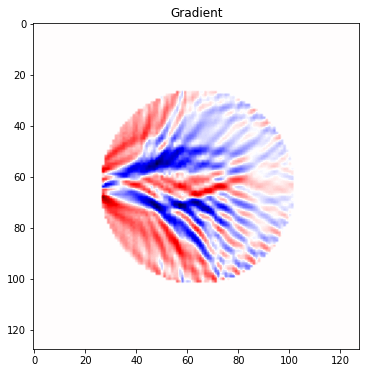

In [21]:
plt.figure(figsize=(8,6))
plt.imshow(gradient, cmap="seismic", vmin=-.2, vmax=.2)
plt.title("Gradient")

In [29]:
losshistory = []
reconstructions = []

init_fun, update_fun, get_params = optimizers.adam(.03, 0.9, 0.9)
opt_state = init_fun(params)

@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    lossval, gradient = loss_with_grad(v, src_num)
    return lossval, update_fun(k, gradient, opt_state)

pbar = tqdm(range(200))
_, key = random.split(key)
for k in pbar:
    _, key = random.split(key)
    lossval, opt_state = update(opt_state, key, k)
    
    # For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_sound_speed(new_params))
    losshistory.append(lossval)
    
    pbar.set_description("Loss: {}".format(lossval))

Loss: 0.3592882454395294: 100%|██████████| 200/200 [01:23<00:00,  2.41it/s] 


In [30]:
new_params = get_params(opt_state)

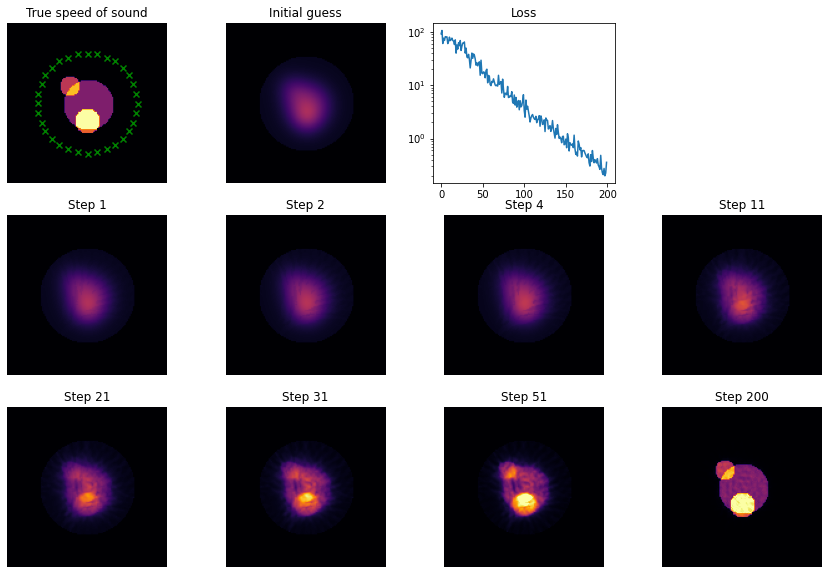

In [31]:
sos_original = get_sound_speed(params)
true_sos = sound_speed

fig, axes = plt.subplots(3,4, figsize=(15,10))

k = 0
recs = [0, 1, 3, 10, 20, 30, 50, 199]
for row in range(3):
    for col in range(4):
        if k ==0:
            axes[row,col].imshow(true_sos, cmap="inferno", vmax=1.2)
            axes[row,col].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='x', label="sensors")
            axes[row,col].set_title("True speed of sound")
            axes[row,col].set_axis_off()
        elif k ==1:
            axes[row,col].imshow(sos_original, cmap="inferno", vmax=1.2)
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Initial guess")
        elif k ==2:
            axes[row,col].plot(losshistory)
            axes[row,col].set_title("Loss")
            axes[row,col].set_yscale("log")
        elif k == 3:
            axes[row,col].set_axis_off()
        else:
            axes[row,col].imshow(reconstructions[recs[k-4]], cmap="inferno", vmax=1.2)
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Step {}".format(recs[k-4]+1))
        k += 1